In [ ]:
!pip install unidecode
!pip install fuzzy-c-means
!pip install --upgrade scikit-learn
!pip install scikit-learn-extra

from fcmeans                          import FCM

# Data Structures
import numpy  as np
import pandas as pd
import json
# Corpus Processing
import re
import nltk
import nltk.corpus
from nltk.tokenize                    import word_tokenize
from nltk                             import SnowballStemmer, PorterStemmer
nltk.download('punkt')

from sklearn.feature_extraction.text  import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing            import normalize, Normalizer
from sklearn.decomposition            import PCA, TruncatedSVD
from sklearn.cluster                  import KMeans, BisectingKMeans, AgglomerativeClustering
from sklearn_extra.cluster            import KMedoids
from sklearn.pipeline                 import make_pipeline

from unidecode                        import unidecode

# K-Means
from sklearn                          import cluster

# Visualization and Analysis
import matplotlib.pyplot  as plt
import matplotlib.cm      as cm
import seaborn            as sns
from sklearn.metrics                  import silhouette_samples, silhouette_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from wordcloud                        import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
np.random.seed(9)

import pandas as pd
#df_book = pd.read_csv("GoF problem domain (complete).csv")
df_book = pd.read_csv("GOF Patterns (2.0).csv")
#df_book['overview'] = df_book['intent'] + " " + df_book['motivation'] + " " + df_book['applicability']
df_book = df_book.drop_duplicates(subset=['name'])

#df_gof = pd.read_csv("scraped_pattern_data_gofpatterns_revised.csv")
df = df_book

In [ ]:
# Add the design problem to the dataset.
#problemRow = {'name':"bridge design problem 1", 'correct_category':1, 'overview':"Design a system enabling to display on a screen some empty windows (no button, no menu…). A window can have several different styles depending on the platform used. We consider two platforms, XWindow and Presentation Manager. The client code must be written independently and without knowledge of the future execution platform. It is probable that the system evolves in order to display specialized windows by ‘application windows’ (able to manage applications) and ‘iconised windows’ (with an icon)"}
#problemRow = {'name':"state design problem 2", 'correct_category':0,  'overview':"Design a DVD market place work. The DVD marketplace provides DVD to its clients with three categories: children, normal and new. A DVD is new during some weeks, and after change category. The DVD price depends on the category. It is probable that the system evolves in order to take into account the horror category"}
problemRow = {'name':"Mediator design problem 2", 'correct_category':0,  'overview':"Design the communications of a plane approaching an airport When a plane approaches an airport, it must announce to all the other planes which are around that it intends to land, and await their confirmation before carrying out the operation. It is the control tower of the airport which guarantees the regulation of the air traffic, by making sure that there is no trajectory or destination conflict between several planes. In addition to the class diagram, you must also submit a collaboration (in the form of a diagram of collaboration or a diagram of objects and sequence) that describes the landing of a plane amidst in a context of two demands to land and one wanting to take off"}
df = df.append(problemRow, ignore_index=True)

# try removing object words from design problem such as DVD, PLANE, etc...

In [ ]:
# removes a list of words (ie. stopwords) from a tokenized list.
def removeWords(listOfTokens, listOfWords):
    return [token for token in listOfTokens if token not in listOfWords]

# applies stemming to a list of tokenized words
def applyStemming(listOfTokens, stemmer):
    return [stemmer.stem(token) for token in listOfTokens]

# removes any words composed of less than 2 or more than 21 letters
def twoLetters(listOfTokens):
    twoLetterWord = []
    for token in listOfTokens:
        if len(token) <= 2 or len(token) >= 21:
            twoLetterWord.append(token)
    return twoLetterWord

In [ ]:
nltk.download('stopwords')
def processCorpus(corpus, language, stemmer):   
    stopwords = nltk.corpus.stopwords.words(language)
    param_stemmer = stemmer
    
    for document in corpus:
        index = corpus.index(document)
        corpus[index] = str(corpus[index]).replace(u'\ufffd', '8')   # Replaces the ASCII '�' symbol with '8'
        corpus[index] = corpus[index].replace(',', '')          # Removes commas
        corpus[index] = corpus[index].rstrip('\n')              # Removes line breaks
        corpus[index] = corpus[index].casefold()                # Makes all letters lowercase
        
        corpus[index] = re.sub('\W_',' ', corpus[index])        # removes specials characters and leaves only words
        corpus[index] = re.sub("\S*\d\S*"," ", corpus[index])   # removes numbers and words concatenated with numbers IE h4ck3r. Removes road names such as BR-381.
        corpus[index] = re.sub("\S*@\S*\s?"," ", corpus[index]) # removes emails and mentions (words with @)
        corpus[index] = re.sub(r'http\S+', '', corpus[index])   # removes URLs with http
        corpus[index] = re.sub(r'www\S+', '', corpus[index])    # removes URLs with www

        listOfTokens = word_tokenize(corpus[index])
        twoLetterWord = twoLetters(listOfTokens)

        listOfTokens = removeWords(listOfTokens, stopwords)
        listOfTokens = removeWords(listOfTokens, twoLetterWord)
        
        listOfTokens = applyStemming(listOfTokens, param_stemmer)

        corpus[index]   = " ".join(listOfTokens)
        corpus[index] = unidecode(corpus[index])

    return corpus

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
corpus = df['overview'].tolist()
corpus[18][0:447]

'Define a one-to-many dependency between objects so that when one object changes state, all its dependents are notified and updated automatically. A common side-effect of partitioning a system into a collection of cooperating classes is the need to maintain consistency between related objects. You don’t want to achieve consistency by making the classes tightly coupled, because that reduces their reusability.\n\nFor example, many graphical user in'

In [ ]:
language = 'english'
stemmer = PorterStemmer()
corpus = processCorpus(corpus, language, stemmer)
corpus[18][0:460]

'defin one-to-mani depend object one object chang state depend notifi updat automat common side-effect partit system collect cooper class need maintain consist relat object want achiev consist make class tightli coupl reduc reusabl exampl mani graphic user interfac toolkit separ present aspect user interfac underli applic data class defin applic data present reus independ work togeth spreadsheet object bar chart object depict inform applic data object use d'

In [ ]:
def vectorize_with_lsa(X_tfidf, n_comp):
  lsa = make_pipeline(TruncatedSVD(n_components=n_comp), Normalizer(copy=False))
  X_lsa = lsa.fit_transform(X_tfidf)
  explained_variance = lsa[0].explained_variance_ratio_.sum()

  print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

  return X_lsa

In [ ]:
vectorizer = TfidfVectorizer(sublinear_tf=True)
X = vectorizer.fit_transform(corpus)
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names_out())

final_df = tf_idf

print("{} rows".format(final_df.shape[0]))
final_df.T.nlargest(5, 0)

24 rows


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
famili,0.287265,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.095526,0.0,0.0,0.0
feel,0.237382,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
and,0.217275,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
widget,0.215456,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.078843,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
factori,0.188132,0.0,0.187026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.094351,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [ ]:
# from google.colab import files
# final_df.to_csv('GOF Patterns (2.0) tfidf sublinear.csv', encoding = 'utf-8-sig') 
# files.download('GOF Patterns (2.0) tfidf sublinear.csv')

In [ ]:
# kmeans = KMeans(
#     n_clusters=3
# )

# kmeans.fit_predict(tf_idf)

In [ ]:
# first 5 words with highest weight on document 0:
final_df.T.nlargest(5, 0)
inertias = []

In [ ]:
def run_KMeans(max_k, data):
    max_k += 1
    kmeans_results = dict()
    for k in range(2 , max_k):
        kmeans = cluster.KMeans(n_clusters = k)
        kmeans_results.update( {k : kmeans.fit(data)} )
        inertias.append((kmeans_results.get(k)).inertia_)
        
    return kmeans_results

In [ ]:
# Running Kmeans
inertias.clear()
k = 19
kmeans_results = run_KMeans(k, final_df)


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: F

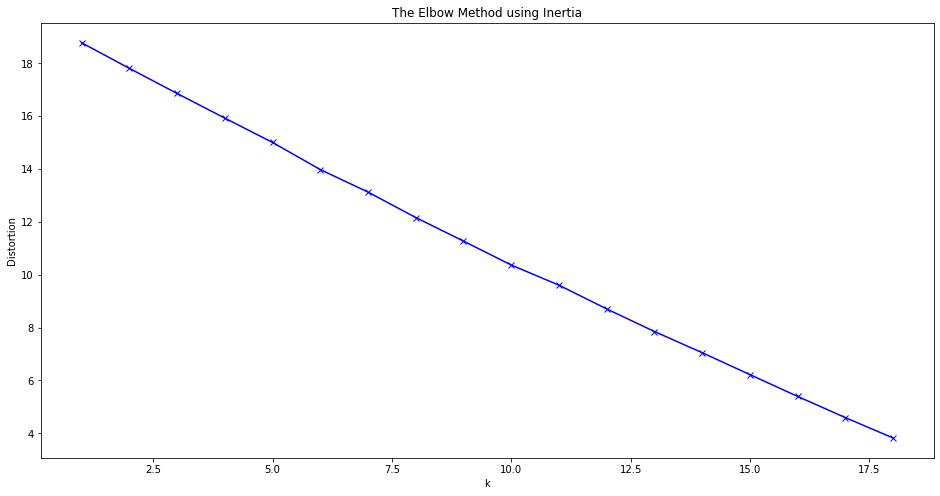

In [ ]:
K = range(1, k)
plt.figure(figsize=(16,8))

# Elbow Method using inertia
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Inertia')
plt.show()

In [ ]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names_out()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

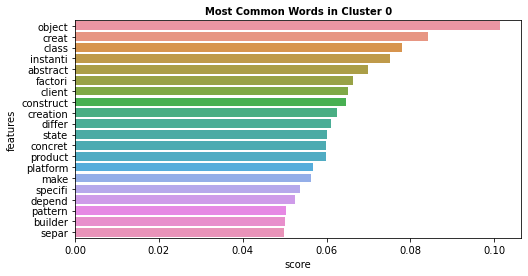

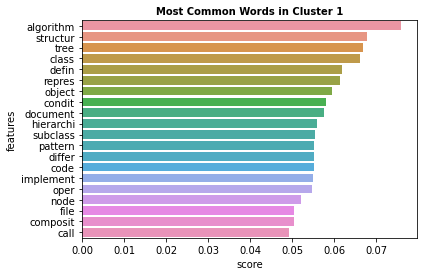

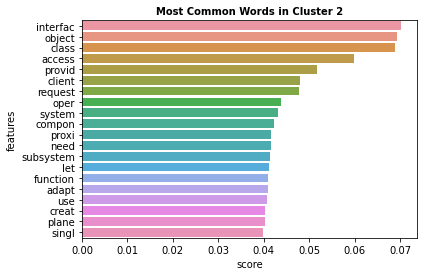

In [ ]:
best_result = 3
kmeans = kmeans_results.get(best_result)

final_df_array = final_df.to_numpy()
prediction = kmeans.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 20)

In [ ]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure()
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

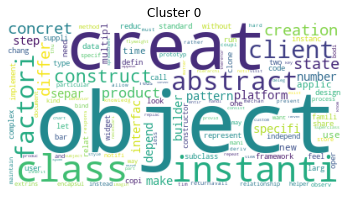

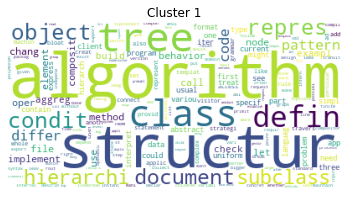

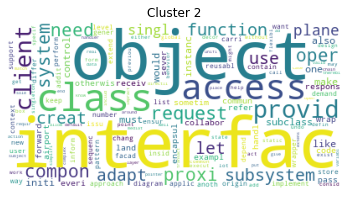

In [ ]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = final_df.columns
generateWordClouds(centroids)

In [ ]:
# Assigning the cluster labels to each pattern
Kmeans_labels = kmeans.labels_ 
df['Kmeans'] = Kmeans_labels

In [ ]:
print("Cluster centroids: \n")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
tempk = 3
for i in range(tempk):
  print("Cluster %d:" % i)
  for j in order_centroids[i, :20]: #print out 10 features terms of each cluster
    print('%s'% terms[j])
  print('------------------')

Cluster centroids: 

Cluster 0:
object
creat
class
instanti
abstract
factori
client
construct
creation
differ
state
concret
product
platform
make
specifi
depend
pattern
builder
separ
------------------
Cluster 1:
algorithm
structur
tree
class
defin
repres
object
condit
document
hierarchi
subclass
pattern
differ
code
implement
oper
node
file
composit
call
------------------
Cluster 2:
interfac
object
class
access
provid
client
request
oper
system
compon
proxi
need
subsystem
let
function
adapt
use
creat
plane
singl
------------------


In [ ]:
# bisecting_strategy{“biggest_inertia”, “largest_cluster”}, default=”biggest_inertia”
Bi_Bisect = BisectingKMeans(n_clusters=3, bisecting_strategy="biggest_inertia")
Lc_Bisect = BisectingKMeans(n_clusters=3, bisecting_strategy="largest_cluster")
Hierarchy = AgglomerativeClustering(n_clusters=3)
Fuzzy_Means = FCM(n_clusters=3)
Fuzzy_Means.fit(final_df_array)
kmed = KMedoids(n_clusters=3)
kmed_manhattan = KMedoids(n_clusters=3,metric='manhattan')

fuzzy_labels = Fuzzy_Means.predict(final_df_array)
bi_bisect_labels = Bi_Bisect.fit_predict(final_df)
lc_bisect_labels = Lc_Bisect.fit_predict(final_df)  
hierarchy_labels = Hierarchy.fit_predict(final_df)
kmed_labels = kmed.fit_predict(final_df)
kmed_man_labels = kmed_manhattan.fit_predict(final_df)

df['fuzzy'] = fuzzy_labels
df['hierarchy'] = hierarchy_labels
df['Bi_Bisect'] = bi_bisect_labels  
df['Lc_Bisect'] = lc_bisect_labels
df['PAM-EUCLIDEAN'] = kmed_labels
df['PAM-MANHATTAN'] = kmed_man_labels


In [ ]:
df

,Unnamed: 0,name,correct_category,overview,Kmeans,fuzzy,hierarchy,Bi_Bisect,Lc_Bisect,PAM-EUCLIDEAN,PAM-MANHATTAN
0,0.0,abstract factory,2,Provide an interface for creating families of ...,0,2,0,0,1,2,1
1,1.0,builder,2,The Builder pattern captures all these relatio...,0,0,0,1,2,1,0
2,2.0,factory method,2,"Define an interface for creating an object, bu...",0,2,0,0,1,2,0
3,3.0,prototype,2,Specify the kinds of objects to create using a...,0,2,0,0,1,0,0
4,4.0,singleton,2,"Ensure a class only has one instance, and prov...",2,2,0,0,1,0,0
5,5.0,adapter,1,Convert the interface of a class into another ...,2,2,0,0,2,2,1
6,6.0,bridge,1,Decouple an abstraction from its implementatio...,0,2,0,0,0,2,1
7,7.0,composite,1,Compose objects into tree structures to repres...,1,1,2,1,0,1,0
8,8.0,decorator,1,Attach additional responsibilities to an objec...,2,2,0,0,1,0,1
9,9.0,facade,1,Provide a unified interface to a set of interf...,2,2,0,0,1,0,1


In [ ]:
# TODO: use k-means before this chunk of code to classify the problem with a pattern class, then perform cosine similarity with the problem and the list of candidate patterns from that class.
# Source: https://danielcaraway.github.io/html/sklearn_cosine_similarity.html



def cosine_sim(df, df_col, class_no):
  unigram_count = CountVectorizer(encoding='latin-1', binary=False)
  unigram_count_stop_remove = CountVectorizer(encoding='latin-1', binary=False, stop_words='english')

  # get the list of candidate patterns
  txts = df_col#.loc[df['label'] == class_no] # where label == class_no
  vecs = unigram_count.fit_transform(txts)
  
  cos_sim = cosine_similarity(vecs[-1], vecs)
  sim_sorted_doc_idx = cos_sim.argsort()

  # print the most similar pattern to the problem; it's actually the problem itself
  print("Design Problem: \n" + txts[sim_sorted_doc_idx[-1][len(txts)-1]] + "\n")

  # print the second most similar pattern; it's likely the best-fitting design pattern for the design problem
  #print(txts[sim_sorted_doc_idx[-1][len(txts)-2]])
  print("\nCorrect Pattern: " + df['name'][sim_sorted_doc_idx[-1][len(txts)-2]] + "\n")

  return cos_sim

cosine_sim(df, df['overview'], df['Kmeans'].iloc[df.index[-1]])

Design Problem: 
Design the communications of a plane approaching an airport When a plane approaches an airport, it must announce to all the other planes which are around that it intends to land, and await their confirmation before carrying out the operation. It is the control tower of the airport which guarantees the regulation of the air traffic, by making sure that there is no trajectory or destination conflict between several planes. In addition to the class diagram, you must also submit a collaboration (in the form of a diagram of collaboration or a diagram of objects and sequence) that describes the landing of a plane amidst in a context of two demands to land and one wanting to take off


Correct Pattern: mediator



array([[0.64737217, 0.58098942, 0.66509168, 0.58380315, 0.58921503,
        0.416709  , 0.65243914, 0.53594201, 0.63272185, 0.55447241,
        0.73637957, 0.69838298, 0.70026168, 0.72556757, 0.69570756,
        0.6538598 , 0.74167337, 0.72951057, 0.69828481, 0.62068371,
        0.68262869, 0.66548812, 0.68144998, 1.        ]])

In [ ]:
df2 = df.pivot_table(index = ['correct_category'], aggfunc ='size')

num_of_creational = df2[2]
num_of_structural = df2[1]
num_of_behavioral = df2[0]

true_1 = [0]*num_of_creational + [1]*num_of_structural + [2]*num_of_behavioral
true_2 = [0]*num_of_creational + [2]*num_of_structural + [1]*num_of_behavioral
true_3 = [1]*num_of_creational + [0]*num_of_structural + [2]*num_of_behavioral
true_4 = [1]*num_of_creational + [2]*num_of_structural + [0]*num_of_behavioral
true_5 = [2]*num_of_creational + [0]*num_of_structural + [1]*num_of_behavioral
true_6 = [2]*num_of_creational + [1]*num_of_structural + [0]*num_of_behavioral


print('===========KMEANS===========')
print('Predicted labels:')
display(Kmeans_labels.tolist())

fscores = [
    f1_score(true_1, Kmeans_labels.tolist(),average='micro'),
    f1_score(true_2, Kmeans_labels.tolist(),average='micro'),
    f1_score(true_3, Kmeans_labels.tolist(),average='micro'),
    f1_score(true_4, Kmeans_labels.tolist(),average='micro'),
    f1_score(true_5, Kmeans_labels.tolist(),average='micro'),
    f1_score(true_6, Kmeans_labels.tolist(),average='micro')
]

km_best = np.around(max(fscores),3)
print('\nBest fscore is:', km_best, 'from true_' + str(np.argmax(fscores) + 1))
display(globals()['true_' + str(np.argmax(fscores) + 1)])

print('===========FUZZY-CMEANS===========')
print('Predicted labels:')
fuzzy_labels = fuzzy_labels.tolist()
display(fuzzy_labels)

fscores = [
    f1_score(true_1, fuzzy_labels,average='micro'),
    f1_score(true_2, fuzzy_labels,average='micro'),
    f1_score(true_3, fuzzy_labels,average='micro'),
    f1_score(true_4, fuzzy_labels,average='micro'),
    f1_score(true_5, fuzzy_labels,average='micro'),
    f1_score(true_6, fuzzy_labels,average='micro')
]

fcm_best = np.around(max(fscores),3)
print('\nBest fscore is:', fcm_best, 'from true_' + str(np.argmax(fscores) + 1))
display(globals()['true_' + str(np.argmax(fscores) + 1)])

print('===========AGGLOMERATIVE===========')
print('Predicted labels:')
display(hierarchy_labels.tolist())

fscores = [
    f1_score(true_1, hierarchy_labels.tolist(),average='micro'),
    f1_score(true_2, hierarchy_labels.tolist(),average='micro'),
    f1_score(true_3, hierarchy_labels.tolist(),average='micro'),
    f1_score(true_4, hierarchy_labels.tolist(),average='micro'),
    f1_score(true_5, hierarchy_labels.tolist(),average='micro'),
    f1_score(true_6, hierarchy_labels.tolist(),average='micro')
]

agg_best = np.around(max(fscores),3)
print('\nBest fscore is:', agg_best, 'from true_' + str(np.argmax(fscores) + 1))
display(globals()['true_' + str(np.argmax(fscores) + 1)])

print('===========PAM-EUCLIDEAN===========')
print('Predicted labels:')
display(kmed_labels.tolist())

fscores = [
    f1_score(true_1, kmed_labels.tolist(),average='micro'),
    f1_score(true_2, kmed_labels.tolist(),average='micro'),
    f1_score(true_3, kmed_labels.tolist(),average='micro'),
    f1_score(true_4, kmed_labels.tolist(),average='micro'),
    f1_score(true_5, kmed_labels.tolist(),average='micro'),
    f1_score(true_6, kmed_labels.tolist(),average='micro')
]

pam_best = np.around(max(fscores),3)
print('\nBest fscore is:', pam_best, 'from true_' + str(np.argmax(fscores) + 1))
display(globals()['true_' + str(np.argmax(fscores) + 1)])

print('===========PAM-MANHATTAN===========')
print('Predicted labels:')
display(kmed_man_labels.tolist())

fscores = [
    f1_score(true_1, kmed_man_labels.tolist(),average='micro'),
    f1_score(true_2, kmed_man_labels.tolist(),average='micro'),
    f1_score(true_3, kmed_man_labels.tolist(),average='micro'),
    f1_score(true_4, kmed_man_labels.tolist(),average='micro'),
    f1_score(true_5, kmed_man_labels.tolist(),average='micro'),
    f1_score(true_6, kmed_man_labels.tolist(),average='micro')
]

pam_manh_best = np.around(max(fscores),3)
print('\nBest fscore is:', pam_manh_best, 'from true_' + str(np.argmax(fscores) + 1))
display(globals()['true_' + str(np.argmax(fscores) + 1)])

print('========BIG-INERTIA-BISECT========')
print('Predicted labels:')
display(bi_bisect_labels.tolist())

fscores = [
    f1_score(true_1, bi_bisect_labels.tolist(),average='micro'),
    f1_score(true_2, bi_bisect_labels.tolist(),average='micro'),
    f1_score(true_3, bi_bisect_labels.tolist(),average='micro'),
    f1_score(true_4, bi_bisect_labels.tolist(),average='micro'),
    f1_score(true_5, bi_bisect_labels.tolist(),average='micro'),
    f1_score(true_6, bi_bisect_labels.tolist(),average='micro')
]

bi_bisect_best = np.around(max(fscores),3)
print('\nBest fscore is:', bi_bisect_best, 'from true_' + str(np.argmax(fscores) + 1))
display(globals()['true_' + str(np.argmax(fscores) + 1)])

print('========LARGE-CLUST-BISECT========')
print('Predicted labels:')
display(lc_bisect_labels.tolist())

fscores = [
    f1_score(true_1, lc_bisect_labels.tolist(),average='micro'),
    f1_score(true_2, lc_bisect_labels.tolist(),average='micro'),
    f1_score(true_3, lc_bisect_labels.tolist(),average='micro'),
    f1_score(true_4, lc_bisect_labels.tolist(),average='micro'),
    f1_score(true_5, lc_bisect_labels.tolist(),average='micro'),
    f1_score(true_6, lc_bisect_labels.tolist(),average='micro')
]

lc_bisect_best = np.around(max(fscores),3)
print('\nBest fscore is:', lc_bisect_best, 'from true_' + str(np.argmax(fscores) + 1))
display(globals()['true_' + str(np.argmax(fscores) + 1)])

===========KMEANS===========
Predicted labels:


[0, 0, 0, 0, 2, 2, 0, 1, 2, 2, 0, 2, 2, 2, 1, 1, 2, 2, 0, 1, 1, 1, 1, 2]


Best fscore is: 0.583 from true_2


[0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

===========FUZZY-CMEANS===========
Predicted labels:


[2, 0, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 2]


Best fscore is: 0.667 from true_2


[0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

===========AGGLOMERATIVE===========
Predicted labels:


[0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2, 2, 1]


Best fscore is: 0.5 from true_3


[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

===========PAM-EUCLIDEAN===========
Predicted labels:


[2, 1, 2, 0, 0, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0]


Best fscore is: 0.5 from true_5


[2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

===========PAM-MANHATTAN===========
Predicted labels:


[1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 2]


Best fscore is: 0.542 from true_6


[2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

========BIG-INERTIA-BISECT========
Predicted labels:


[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2]


Best fscore is: 0.625 from true_2


[0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

========LARGE-CLUST-BISECT========
Predicted labels:


[1, 2, 1, 1, 1, 2, 0, 0, 1, 1, 0, 1, 0, 1, 2, 1, 0, 1, 2, 2, 1, 1, 2, 0]


Best fscore is: 0.458 from true_3


[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

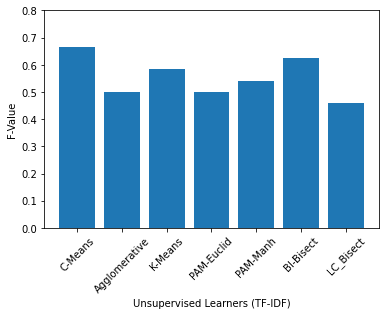

In [ ]:
data = [fcm_best, agg_best, km_best, pam_best, pam_manh_best, bi_bisect_best, lc_bisect_best]
labels = ['C-Means', 'Agglomerative', 'K-Means','PAM-Euclid','PAM-Manh', 'BI-Bisect', 'LC_Bisect']
plt.xticks(range(len(data)), labels)
plt.ylim([0, 0.8])
plt.xlabel('Unsupervised Learners (TF-IDF)')
plt.ylabel('F-Value')
plt.bar(range(len(data)), data) 
plt.xticks(rotation=45)
plt.show()